## Backwater curves

Simple gradually varied flow solver for a trapezoidal channel (backwater profile, subcritical).

In [ ]:
# Imports and fixed inputs for the trapezoidal channel case
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

# Geometry and flow
b = 10.0                # base width (m)
m = 1.0                 # bank slope (horizontal:vertical)
n = 0.05                # Manning's n
S0 = 0.001              # bed slope (m/m)
L = 500.0               # reach length (m)
Q = 10.0                # discharge (m3/s)

# Boundary conditions
bed_z0 = 0.0            # bed elevation at downstream end (m a.s.l.)
stage_ds = 0.7          # downstream water level (m a.s.l.)

# Numerics
g = 9.81                # gravity (m/s2)
dx = 0.1               # step size (m), matches 1 m cross-sections


In [8]:
# Hydraulic helper functions for a trapezoidal section

def area(y: float) -> float:
    return y * (b + m * y)

def top_width(y: float) -> float:
    return b + 2 * m * y

def wetted_perimeter(y: float) -> float:
    return b + 2 * y * np.sqrt(1 + m**2)

def hydraulic_radius(y: float) -> float:
    return area(y) / wetted_perimeter(y)

def friction_slope(y: float, q: float = Q) -> float:
    A = area(y)
    R = hydraulic_radius(y)
    return (n**2 * q**2) / (A**2 * R**(4/3))

def froude_sq(y: float, q: float = Q) -> float:
    A = area(y)
    T = top_width(y)
    D = A / T
    V = q / A
    return V**2 / (g * D)

def dy_dx_upstream(y: float) -> float:
    Fr2 = froude_sq(y)
    denom = 1.0 - Fr2
    if np.isclose(denom, 0.0):
        denom = 1e-8
    
    sf = friction_slope(y)
    return (S0 - sf) / denom


In [11]:
# Backwater computation: normal/critical depths + simple Euler integration

def solve_depth(func, y_low=1e-3, y_high=20.0, tol=1e-6, max_iter=200):
    f_low = func(y_low)
    f_high = func(y_high)
    if f_low * f_high > 0:
        return np.nan
    for _ in range(max_iter):
        y_mid = 0.5 * (y_low + y_high)
        f_mid = func(y_mid)
        if abs(f_mid) < tol:
            return y_mid
        if f_low * f_mid < 0:
            y_high, f_high = y_mid, f_mid
        else:
            y_low, f_low = y_mid, f_mid
    return y_mid

y_normal = solve_depth(lambda y: friction_slope(y) - S0)
y_critical = solve_depth(lambda y: froude_sq(y) - 1.0)

def euler_profile(y0: float, x: np.ndarray) -> np.ndarray:
    y = np.zeros_like(x)
    y[0] = y0
    for i in range(len(x) - 1):
        dx_ = x[i + 1] - x[i]
        dydx_up = dy_dx_upstream(y[i])
        y[i + 1] = y[i] - dx_ * dydx_up
    return y

# Set up grid and boundary depth
x = np.arange(0.0, L + dx, dx)
bed_z = bed_z0 + S0 * x

y_profile = euler_profile(stage_ds, x)
water_level = bed_z + y_profile
velocity = Q / np.maximum(area(y_profile), 1e-6)
fr2_profile = froude_sq(y_profile)
froude = np.sqrt(fr2_profile)
v_head = velocity**2 / (2 * g)
head = water_level + v_head

# Tabulate key values
profile_df = pd.DataFrame({
    "x_m": x,
    "bed_z_m": bed_z,
    "depth_m": y_profile,
    "wse_m": water_level,
    "velocity_m_per_s": velocity,
    "head_m": head,
    "Fr": froude,
})

print(f"Normal depth ≈ {y_normal:.3f} m")
print(f"Critical depth ≈ {y_critical:.3f} m")
display(profile_df.loc[0:50:5])


Normal depth ≈ 1.321 m
Critical depth ≈ 0.460 m


,x_m,bed_z_m,depth_m,wse_m,velocity_m_per_s,head_m,Fr
0,0.0,0.000,0.700000,0.700000,1.335113,0.790853,0.525890
5,5.0,0.005,0.744671,0.749671,1.249805,0.829285,0.478163
10,10.0,0.010,0.778959,0.788959,1.190991,0.861256,0.446137
15,15.0,0.015,0.807127,0.822127,1.146430,0.889115,0.422360
20,20.0,0.020,0.831176,0.851176,1.110789,0.914063,0.403651
25,25.0,0.025,0.852225,0.877225,1.081252,0.936813,0.388357
30,30.0,0.030,0.870978,0.900978,1.056147,0.957830,0.375511
35,35.0,0.035,0.887904,0.922904,1.034402,0.977440,0.364498
40,40.0,0.040,0.903340,0.943340,1.015288,0.995878,0.354906
45,45.0,0.045,0.917530,0.962530,0.998287,1.013324,0.346445


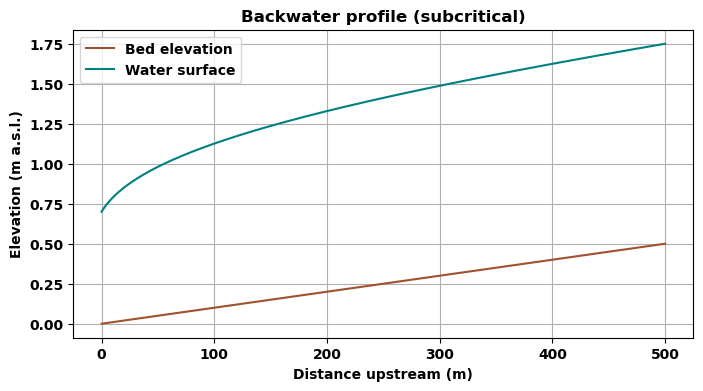

,x_m,bed_z_m,depth_m,wse_m,velocity_m_per_s,head_m,Fr
496,496.0,0.496,1.248791,1.744791,0.711876,1.770621,0.214380
497,497.0,0.497,1.249007,1.746007,0.711739,1.771826,0.214322
498,498.0,0.498,1.249221,1.747221,0.711604,1.773031,0.214265
499,499.0,0.499,1.249435,1.748435,0.711468,1.774235,0.214207
500,500.0,0.500,1.249648,1.749648,0.711334,1.775438,0.214150


In [10]:
# Plot water surface and bed profile
fig, ax = plt.subplots()
ax.plot(x, bed_z, label="Bed elevation", color="sienna")
ax.plot(x, water_level, label="Water surface", color="teal")
ax.set_xlabel("Distance upstream (m)")
ax.set_ylabel("Elevation (m a.s.l.)")
ax.legend()
ax.set_title("Backwater profile (subcritical)")
plt.show()

profile_df.tail()
